## Import some libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Specify the Power Network

In [2]:
n = 30 # number of nodes 

nodes = range(n) # enumerates all node

In [3]:
network_name = "ieee" + str(n)
filename = network_name + ".xlsx"

## Import the dataset

In [4]:
dataset = pd.read_excel(filename,sheet_name = "dataset")

dataset.head() # Returns the first 5 rows in the data

,PD1,PD2,PD3,PD4,PD5,PD6,PD7,PD8,PD9,PD10,...,PD17,PD18,PD19,PD20,PG1,PG2,PG3,PG4,PG5,PG6
0,19.788746,2.487347,6.904495,20.845791,30.129899,5.332207,11.912653,6.593758,8.564801,3.254906,...,8.582361,3.727720,2.200066,9.822323,44.394362,57.879270,22.206196,31.521251,15.515489,15.515489
1,20.282507,2.347650,8.103697,24.183342,27.362827,5.683139,11.260202,6.096831,8.457250,3.589581,...,8.477993,3.288683,2.395050,10.259726,43.901203,57.315660,22.048385,30.338615,15.120962,15.120962
2,23.660076,2.601759,6.920069,23.884633,28.614717,5.710489,11.307231,6.748994,8.065100,3.838137,...,8.139950,3.239610,2.639559,9.902777,44.974087,58.541814,22.391708,32.911480,15.979270,15.979270
3,19.671488,2.429376,8.180437,23.571439,28.142600,5.647943,11.112026,6.797231,7.636504,3.748866,...,8.855743,3.308331,2.344617,10.775931,44.246910,57.710754,22.159011,31.167648,15.397528,15.397528
4,20.622839,2.299412,7.777978,21.729681,31.946258,6.359890,11.715757,6.006407,8.337874,3.225438,...,8.569951,3.368903,2.237513,9.918984,44.886903,58.442175,22.363809,32.702406,15.909523,15.909523


# Data Preprocessing

In [5]:
node_type = pd.read_excel(filename, sheet_name = "n") # if type is load or generator 

n_loads = node_type["n_loads"][0] # get the number of generator nodes
n_gens = node_type["n_gens"][0] # get the number of load nodes 

In [6]:
# Changing pandas dataframe to numpy arrays:

X = dataset.iloc[:,:n_loads].values
y = dataset.iloc[:,n_loads:n_loads+n_gens].values

### Normalize the target 

In [7]:
# load generator data

gen = pd.read_excel(filename,sheet_name="Gen")

gen.head()

,bus,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax,Pmin,...,Pc2,Qc1min,Qc1max,Qc2min,Qc2max,ramp_agc,ramp_10,ramp_30,ramp_q,apf
0,0,23.54,0,150.0,-20,1,100,1,80,0,...,0,0,0,0,0,0,0,0,0,0
1,1,60.97,0,60.0,-20,1,100,1,80,0,...,0,0,0,0,0,0,0,0,0,0
2,21,21.59,0,62.5,-15,1,100,1,50,0,...,0,0,0,0,0,0,0,0,0,0
3,26,26.91,0,48.7,-15,1,100,1,55,0,...,0,0,0,0,0,0,0,0,0,0
4,22,19.20,0,40.0,-10,1,100,1,30,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# store the maximum and minimum power vectors 

P_G_max =  gen["Pmax"].values

P_G_min = gen["Pmin"].values

In [9]:
# normalize the target

N = len(y) # number of samples

for i in range(N):
    for j in range(n_gens):
        y[i][j] = ( y[i][j] - P_G_min[j] ) / (P_G_max[j] - P_G_min[j])

## Split the data & Normalize the input

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [11]:
#Feature Scaling of datasets  

from sklearn.preprocessing import StandardScaler  

st_x= StandardScaler()  

X_train= st_x.fit_transform(X_train)  

X_test= st_x.transform(X_test) 

# Neural Network

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense

### Network Architecture

In [13]:
model = Sequential()

initializer = keras.initializers.HeUniform(seed=1)

layer1 = Dense(32, input_dim=n_loads, activation='relu', kernel_initializer = initializer)
layer2 = Dense(16, activation='relu',kernel_initializer = initializer)
layer3 = Dense(8, activation='relu',kernel_initializer = initializer)
layer4 = Dense(n_gens, activation='linear',kernel_initializer = initializer)

model.add(layer1)
model.add(layer2)
model.add(layer3)
model.add(layer4)

## Draw the network architecture

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Loss Function and Optimizer

In [15]:
import keras.backend as K

def custom_mse(y_true, y_pred):
 
    # calculating squared difference between target and predicted values 
    loss1 = K.square(y_pred - y_true)  # (batch_size, 2)
                
    # summing both loss values along batch dimension 
    loss1 = K.mean(loss1, axis=1)        # (batch_size,)
    
    # generator limits 
    
    loss2 = K.maximum(y_pred - 1, 0)
    loss2 = K.mean(loss2, axis = 1)
    
    loss3 = K.maximum(- y_pred , 0)
    loss3 = K.mean(loss3, axis = 1)
    
    w1 = 1
    w2 = 1
    
    loss = w1 * loss1 + w2 * (loss2 + loss3)
    
    return loss

In [16]:
sgd = keras.optimizers.SGD(learning_rate=1e-3, momentum = 0.5) 

adam = keras.optimizers.Adam(learning_rate = 1e-3)

#model.compile(loss=custom_mse, optimizer= adam, metrics=['mae'])
model.compile(loss='mse', optimizer=adam, metrics=['mse'])

### Train the model:

In [17]:
history=model.fit(X_train, y_train, epochs=300, batch_size=64, verbose=1, validation_split=0.2)

Epoch 1/300
88/88 [==============================] - 3s 18ms/step - loss: 0.2382 - mse: 0.2382 - val_loss: 0.0892 - val_mse: 0.0892
Epoch 2/300
88/88 [==============================] - 0s 5ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 3/300
88/88 [==============================] - 0s 4ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 4/300
88/88 [==============================] - 0s 4ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 5/300
88/88 [==============================] - 1s 8ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 6/300
88/88 [==============================] - 1s 8ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 7/300
88/88 [==============================] - 1s 8ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 8/300
88/88 [==============================] - 1s 6ms/step - loss: 0.0029 - 

88/88 [==============================] - 1s 8ms/step - loss: 2.9190e-05 - mse: 2.9190e-05 - val_loss: 5.2164e-05 - val_mse: 5.2164e-05
Epoch 59/300
88/88 [==============================] - 1s 8ms/step - loss: 2.7904e-05 - mse: 2.7904e-05 - val_loss: 5.4165e-05 - val_mse: 5.4165e-05
Epoch 60/300
88/88 [==============================] - 1s 8ms/step - loss: 2.7137e-05 - mse: 2.7137e-05 - val_loss: 5.1160e-05 - val_mse: 5.1160e-05
Epoch 61/300
88/88 [==============================] - 1s 8ms/step - loss: 2.5709e-05 - mse: 2.5709e-05 - val_loss: 5.0990e-05 - val_mse: 5.0990e-05
Epoch 62/300
88/88 [==============================] - 1s 8ms/step - loss: 2.4985e-05 - mse: 2.4985e-05 - val_loss: 4.8620e-05 - val_mse: 4.8620e-05
Epoch 63/300
88/88 [==============================] - 1s 8ms/step - loss: 2.4686e-05 - mse: 2.4686e-05 - val_loss: 4.8625e-05 - val_mse: 4.8625e-05
Epoch 64/300
88/88 [==============================] - 1s 8ms/step - loss: 2.4987e-05 - mse: 2.4987e-05 - val_loss: 4.7245e-05

88/88 [==============================] - 1s 6ms/step - loss: 7.9024e-06 - mse: 7.9024e-06 - val_loss: 2.8915e-05 - val_mse: 2.8915e-05
Epoch 114/300
88/88 [==============================] - 1s 8ms/step - loss: 7.4732e-06 - mse: 7.4732e-06 - val_loss: 2.7633e-05 - val_mse: 2.7633e-05
Epoch 115/300
88/88 [==============================] - 1s 8ms/step - loss: 7.1462e-06 - mse: 7.1462e-06 - val_loss: 2.6307e-05 - val_mse: 2.6307e-05
Epoch 116/300
88/88 [==============================] - 1s 8ms/step - loss: 7.3651e-06 - mse: 7.3651e-06 - val_loss: 2.6182e-05 - val_mse: 2.6182e-05
Epoch 117/300
88/88 [==============================] - 1s 8ms/step - loss: 7.0220e-06 - mse: 7.0220e-06 - val_loss: 2.7300e-05 - val_mse: 2.7300e-05
Epoch 118/300
88/88 [==============================] - 1s 9ms/step - loss: 7.0810e-06 - mse: 7.0810e-06 - val_loss: 2.6242e-05 - val_mse: 2.6242e-05
Epoch 119/300
88/88 [==============================] - 1s 6ms/step - loss: 6.5006e-06 - mse: 6.5006e-06 - val_loss: 2.54

88/88 [==============================] - 0s 6ms/step - loss: 5.7231e-08 - mse: 5.7231e-08 - val_loss: 8.9407e-06 - val_mse: 8.9407e-06
Epoch 169/300
88/88 [==============================] - 1s 8ms/step - loss: 5.6415e-08 - mse: 5.6415e-08 - val_loss: 8.8728e-06 - val_mse: 8.8728e-06
Epoch 170/300
88/88 [==============================] - 1s 9ms/step - loss: 1.5401e-07 - mse: 1.5401e-07 - val_loss: 8.8549e-06 - val_mse: 8.8549e-06
Epoch 171/300
88/88 [==============================] - 1s 9ms/step - loss: 2.8127e-08 - mse: 2.8127e-08 - val_loss: 8.8936e-06 - val_mse: 8.8936e-06
Epoch 172/300
88/88 [==============================] - 1s 8ms/step - loss: 1.1010e-07 - mse: 1.1010e-07 - val_loss: 9.8401e-06 - val_mse: 9.8401e-06
Epoch 173/300
88/88 [==============================] - 0s 5ms/step - loss: 4.1898e-07 - mse: 4.1898e-07 - val_loss: 8.9115e-06 - val_mse: 8.9115e-06
Epoch 174/300
88/88 [==============================] - 0s 5ms/step - loss: 1.1951e-08 - mse: 1.1951e-08 - val_loss: 8.99

88/88 [==============================] - 1s 8ms/step - loss: 1.5569e-07 - mse: 1.5569e-07 - val_loss: 1.0147e-05 - val_mse: 1.0147e-05
Epoch 224/300
88/88 [==============================] - 1s 9ms/step - loss: 9.6918e-08 - mse: 9.6918e-08 - val_loss: 1.0016e-05 - val_mse: 1.0016e-05
Epoch 225/300
88/88 [==============================] - 1s 10ms/step - loss: 3.9779e-09 - mse: 3.9779e-09 - val_loss: 9.9964e-06 - val_mse: 9.9964e-06
Epoch 226/300
88/88 [==============================] - 0s 3ms/step - loss: 3.5136e-09 - mse: 3.5136e-09 - val_loss: 9.9969e-06 - val_mse: 9.9969e-06
Epoch 227/300
88/88 [==============================] - 0s 3ms/step - loss: 3.4985e-08 - mse: 3.4985e-08 - val_loss: 1.0011e-05 - val_mse: 1.0011e-05
Epoch 228/300
88/88 [==============================] - 0s 3ms/step - loss: 1.9409e-07 - mse: 1.9409e-07 - val_loss: 1.0011e-05 - val_mse: 1.0011e-05
Epoch 229/300
88/88 [==============================] - 1s 9ms/step - loss: 5.7260e-08 - mse: 5.7260e-08 - val_loss: 1.0

88/88 [==============================] - 0s 3ms/step - loss: 1.7313e-07 - mse: 1.7313e-07 - val_loss: 4.7521e-06 - val_mse: 4.7521e-06
Epoch 279/300
88/88 [==============================] - 0s 6ms/step - loss: 4.5101e-08 - mse: 4.5101e-08 - val_loss: 4.7137e-06 - val_mse: 4.7137e-06
Epoch 280/300
88/88 [==============================] - 1s 6ms/step - loss: 6.1731e-08 - mse: 6.1731e-08 - val_loss: 4.7642e-06 - val_mse: 4.7642e-06
Epoch 281/300
88/88 [==============================] - 0s 6ms/step - loss: 9.3938e-08 - mse: 9.3938e-08 - val_loss: 4.7792e-06 - val_mse: 4.7792e-06
Epoch 282/300
88/88 [==============================] - 0s 5ms/step - loss: 3.1013e-08 - mse: 3.1013e-08 - val_loss: 4.7360e-06 - val_mse: 4.7360e-06
Epoch 283/300
88/88 [==============================] - 0s 5ms/step - loss: 1.0878e-07 - mse: 1.0878e-07 - val_loss: 4.7896e-06 - val_mse: 4.7896e-06
Epoch 284/300
88/88 [==============================] - 0s 5ms/step - loss: 1.2928e-07 - mse: 1.2928e-07 - val_loss: 4.83

### Plot the training error

In [18]:
print(history.history.keys()) # components that can be plotted

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


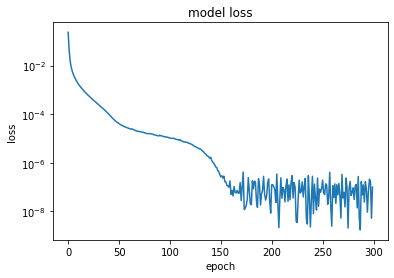

In [19]:
plt.plot(history.history['loss']) # plot the training loss

#plt.plot(history.history['val_loss']) # plot the validation loss 

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

#plt.legend(['train', 'validation'], loc='upper left') # use legend if validation loss is also plotted

plt.yscale('log') # log scale plot

plt.show()

### Evaluate the Model

In [20]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

In [21]:
y_pred = model.predict(X_test)

percentage_error = mape(y_pred,y_test)

mean_squared_error = mse(y_pred,y_test)

94/94 [==============================] - 1s 4ms/step


In [22]:
print("the percentage error is: ", round(percentage_error*100,2),"%")
print("the mean squared error is: ", mean_squared_error, )
print("the mean squared error of a dummy model is: ", 2*(0.5)**2)

the percentage error is:  0.09 %
the mean squared error is:  1.850341204876662e-05
the mean squared error of a dummy model is:  0.5


### Inverse Transform the predicted and test data

In [23]:
predicted = y_pred * (P_G_max - P_G_min)  + P_G_min
actual = y_test * (P_G_max - P_G_min)  + P_G_min

In [24]:
def column_namer(name, n):
    # returns an array of the names of columns of a dataframe
    # name is the string that is repeated in all columns
    # n is the number of such columns 
    
    columns = []
    
    for i in range(n):
        columns.append(name+str(i+1))
    
    return columns

In [25]:
input_matrix = st_x.inverse_transform(X_test)
actual_target = actual 
predicted_target = predicted

columns_PD = column_namer("PD",n_loads)

test_data = pd.DataFrame(input_matrix, columns=columns_PD)

for i in range(n_gens):
    test_data["PG"+str(i+1)+"_"+"test"] = actual[:,i]
    test_data["PG"+str(i+1)+"_"+"pred"] = predicted[:,i]

test_data.head()

,PD1,PD2,PD3,PD4,PD5,PD6,PD7,PD8,PD9,PD10,...,PG2_test,PG2_pred,PG3_test,PG3_pred,PG4_test,PG4_pred,PG5_test,PG5_pred,PG6_test,PG6_pred
0,20.373874,2.518507,7.562849,23.179659,28.563288,5.318394,10.747818,6.717240,8.151650,3.338627,...,57.874280,57.857361,22.204799,22.197926,31.510778,31.505520,15.511996,15.506646,15.511996,15.504433
1,21.086838,2.429159,8.026110,22.342184,30.894099,5.698992,10.340713,6.348665,8.326624,3.529588,...,58.475681,58.450146,22.373191,22.364135,32.772711,32.757528,15.932976,15.923247,15.932976,15.920594
2,20.897990,2.394189,6.867199,23.401042,31.527076,5.840364,10.793929,6.341567,7.948685,3.458284,...,58.290188,58.264818,22.321253,22.314462,32.383488,32.368442,15.803132,15.792902,15.803132,15.790795
3,23.406645,2.614595,7.405897,23.646149,32.947698,5.532945,10.348893,6.433159,8.252307,3.312791,...,59.060596,59.021244,22.536967,22.529265,34.000051,33.968854,16.342417,16.324394,16.342417,16.322206
4,20.533139,2.460550,7.897639,23.970808,29.658627,6.079893,11.737793,6.323484,7.663929,3.395631,...,58.161595,58.133240,22.285247,22.278923,32.113657,32.091938,15.713117,15.700368,15.713117,15.698603


In [26]:
sum(sum(predicted >= P_G_max)) + sum(sum(predicted <= P_G_min)) 

0

## Check how many line flow violations:

In [27]:
test_size = len(X_test)

In [28]:
# load the branch data 

branch = pd.read_excel(filename,sheet_name="Branch")

branch.head()

,fbus,tbus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax
0,0,1,0.02,0.06,0.03,130,130,130,0,0,1,-360,360
1,0,2,0.05,0.19,0.02,130,130,130,0,0,1,-360,360
2,1,3,0.06,0.17,0.02,65,65,65,0,0,1,-360,360
3,2,3,0.01,0.04,0.00,130,130,130,0,0,1,-360,360
4,1,4,0.05,0.20,0.02,130,130,130,0,0,1,-360,360


In [29]:
# define line-related vectors 

P_flow = branch["rateA"]
reactance = branch["x"]

line_from = branch["fbus"].tolist()
line_to = branch["tbus"].tolist()

L = len(P_flow) # number of lines 

In [30]:
P_G = np.zeros([test_size,n])
P_G[G_buses].shape

NameError: name 'G_buses' is not defined

In [ ]:
# load bus data

bus = pd.read_excel(filename,sheet_name="Bus")

bus.head()

In [ ]:
# Find the power vector

D_buses = bus[bus["Pd"] != 0]["bus"]
P_D = np.zeros([test_size,n])

G_buses = gen["bus"]
P_G = np.zeros([test_size,n])

for i in range(test_size):
    P_D[i][D_buses] = input_matrix[i]
    P_G[i][G_buses] = predicted[i] 

P = P_D - P_G

In [ ]:
def theta_calculator(B_inv, P):
    
    return np.dot(B_inv, P)

In [ ]:
def print_matrix(a):
    
    for line in a:
        print ('  '.join(map(str, line)))

In [ ]:
admittance = 1 / reactance

# construct the bus-admittance matrix

B = np.zeros([n,n])


for line in range(L):
    
    i = line_from[line] 
    j = line_to[line] 
    
    B[i][j] = - admittance[line]
    B[j][i] = - admittance[line]

    
for node in nodes:
    
    B[node][node] = - (sum (B[node][j] for j in nodes))

B

In [ ]:
B_prime = B

for i in range(n):
    B_prime[0][i] = 0
    B_prime[i][0] = 0

B_prime[0][0] = 1
    
B_inv = np.linalg.inv(B_prime) 

In [ ]:
# convert all vectors to per unit at 100 MVA base

base = pd.read_excel(filename,sheet_name="Base")
Base = base["Base"][0]

In [ ]:
P_pu = P/Base
P_pu[0] = 0

In [ ]:
theta = np.zeros([test_size,n])

for i in range(test_size):
    theta[i] = theta_calculator(B_inv,P_pu[i])

In [ ]:
# line flow constraints

count_violations_per_sample = []
count_violating_samples = 0

for sample in range(test_size):
    
    theta_sample = theta[sample]
    
    violations_per_sample = 0

    for line in range(L):

        bound = reactance[line] * P_flow[line]
        i = line_from[line] 
        j = line_to[line] 

        if (theta_sample[i] - theta_sample[j] >= bound or theta_sample[i] - theta_sample[j] <= - bound):
            violatons_per_sample+=1
    
    count_violations_per_sample.append(violations_per_sample)
    
    if violations_per_sample != 0:
        count_violating_samples += 1

count_violating_samples

### Test on a new instance of the demand 

In [ ]:
import random

In [ ]:
# get the default values

default_load = pd.read_excel(filename, sheet_name = "PD_Default")
P_D_default = default_load["PD_Default"].values

In [ ]:
# get the margin of variation from default

margin = pd.read_excel(filename,sheet_name = "delta")
delta = margin["delta"][0]

In [ ]:
P_D_new = []
for i in range(n_loads):
    
    lower_bound = P_D_default[i] * (1 - delta)
    upper_bound = P_D_default[i] * (1 + delta)
    
    random_demand = random.uniform(lower_bound,upper_bound)
    
    P_D_new.append(random_demand)


x_new = st_x.transform([P_D_new])
y_new = model.predict(x_new)

y_new = y_new * (P_G_max - P_G_min) + P_G_min

print(np.round(P_D_new,2))
print(np.round(y_new,2))

In [ ]:
gen = pd.read_excel(filename,sheet_name="Gen")
G_buses = gen["bus"]

In [ ]:
'''from project import project

#import numpy as np

N = len(X_test) # number of test samples

y_pred_projected_intermediate = np.zeros([N,n])
y_pred_projected = np.zeros([N,n_gens])

for i in range(N):
    y_pred_projected_intermediate[i] = project(input_matrix[i], predicted[i], n)
    y_pred_projected[i] = y_pred_projected_intermediate[i][G_buses]'''

In [ ]:
y_pred_projected = y_pred_projected*100

In [ ]:
percentage_error = mape(y_pred_projected,actual)

mean_squared_error = mse(y_pred_projected,actual)

print("the percentage error is: ", round(percentage_error*100,2),"%")
print("the mean squared error is: ", mean_squared_error, )
#print("the mean squared error of a dummy model is: ", 2*(0.5)**2)